In [18]:
import numpy as np
from trotter import *

# Clock Hamiltonian

\begin{equation}
H=J\sum_i \sum_{m=1}^{n-1} \alpha_m \sigma_i^m \sigma_{i+1}^{-m}+g\sum_i \sum_{m=1}^{n-1} \beta_m \tau_i^m
\end{equation}

In [221]:
dim = 3 # order of the clock (n) 
g = -1.0; J = float("{0:.5f}".format(-1-g)); theta = 0; phi = 0;
alpha = np.array([np.exp(1j*theta),np.exp(-1j*theta)])
beta = np.array([np.exp(1j*phi),np.exp(1j*phi)])

chi = 10; delta = 0.01; N = 500

#### Construct operators

In [225]:
sigma = np.diag(np.exp(1j*2*np.pi*np.arange(dim)/dim))
tau = np.roll(np.eye(dim), -1, axis = -1)
interactions = list(zip(J*alpha, [sigma**m for m in range(1,dim)], [sigma**(dim-m) for m in range(1,dim)]))
transv_field = list(zip(g*beta, [tau**m for m in range(1,dim)]))
U=ST_step(delta, interactions, transv_field)

#### Initialization with random state

In [133]:
GA0 = np.random.rand(dim,chi,chi)
LA0 = np.random.rand(chi)
GB0 = np.random.rand(dim,chi,chi)
LB0 = np.random.rand(chi)

#### iTEBD

In [134]:
res={}
res_names = ["Energy", "SigmaA", "SigmaB"]

GA = GA0; LA = LA0; GB = GB0; LB=LB0
discarded_weights = []
for step in range(N):
    GA, LA, GB, dw, norm_sq = iTEDB(dim, chi, GA, LA, GB, LB, U)
    E_sim =-np.log(norm_sq)/delta/2
    discarded_weights.append(dw)
    GB, LB, GA, dw, norm_sq = iTEDB(dim, chi, GB, LB, GA, LA, U)
    E_sim =-np.log(norm_sq)/delta/2
    discarded_weights.append(dw)
res["Energy"] = E_sim
res["SigmaA"] = np.einsum('sab,tab,st,b,a->', GA, np.conj(GA), sigma, LA**2, LB**2)
res["SigmaB"] = np.einsum('sab,tab,st,b,a->', GB, np.conj(GB), sigma, LB**2, LA**2)

for key in res_names: print(key, res[key])
#print("Discarder weights", discarded_weights)
#print("Entanglement spectrum", LB**2)

Energy -2.0000000000000204
SigmaA (-2.3819654637601963e-08-1.0373955250386686e-08j)
SigmaB (-1.252273063272242e-08-2.1077886701317884e-09j)


#### Save to file

In [135]:
File_code = '{}J_{}g_{}theta_{}phi_{}Chi_{}delta_{}N'.format(J, g, theta, phi, chi, delta,N)
!mkdir -p {'clock3/data_'+File_code}

Outfile1 = './clock3/data_{}/Results.dat'.format(File_code)
Outfile2 = './clock3/data_{}/EntanglementSpectrum.dat'.format(File_code)
Outfile3 = './clock3/data_{}/DiscardedWeights.dat'.format(File_code)

with open(Outfile1, 'w') as f1:
    print('# ', File_code, file=f1)
    print('# ', *res_names, file=f1)
    print(*[res[key] for key in res_names], file=f1)
np.savetxt(Outfile2, LB**2, header=File_code)
np.savetxt(Outfile3, discarded_weights, header=File_code)

# Analysis of the 3-state clock model

\begin{equation}
H=J\sum_i (e^{i\theta}\sigma_i \sigma_{i+1}^\dagger + h.c.)+g\sum_i (e^{i\varphi} \tau_i+h.c.)
\end{equation}

In [136]:
import glob
import re

#### Read data files

In [212]:
datalist=[]
for name in glob.glob('clock3/data_*J_*g_*theta_*phi_*Chi_*delta_*N'):
    ES = np.loadtxt('{}/EntanglementSpectrum.dat'.format(name))
    EE = -np.sum(ES*np.log(ES))
    res = np.genfromtxt('{}/Results.dat'.format(name), dtype=(np.float64, np.complex128, np.complex128))
    m = re.match('clock3/data_(.*)J_(.*)g_(.*)theta_(.*)phi_(.*)Chi_(.*)delta_(.*)N', name)
    datalist.append(np.array([(*m.groups(), *res.item(), EE)],\
             dtype=[\
                    ('J', np.float64), ('g', np.float64), ('theta', np.float64),\
                    ('phi', np.float64), ('chi', np.int32), ('delta', np.float64), ('N', np.int32),\
                    ('Energy', np.float64), ('SigmaA', np.complex128), ('SigmaB', np.complex128),\
                    ('EE', np.float64)]))
datalist = sorted(datalist, key= lambda x: (x['phi'], x['J'], x['theta']))
data = np.array(datalist)
data = np.reshape(data, (3,11,11))

#### Plot

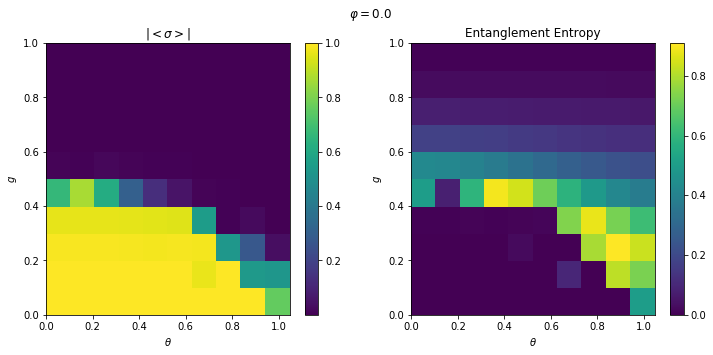

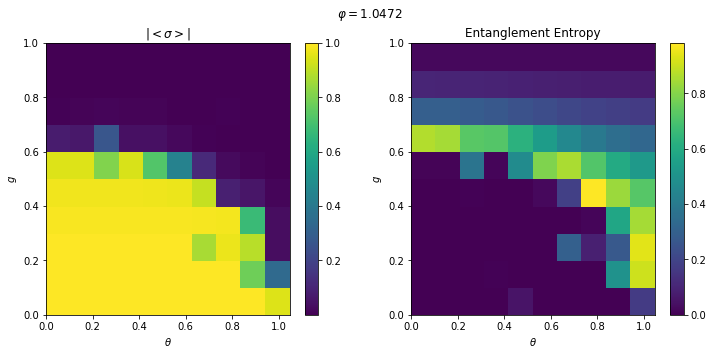

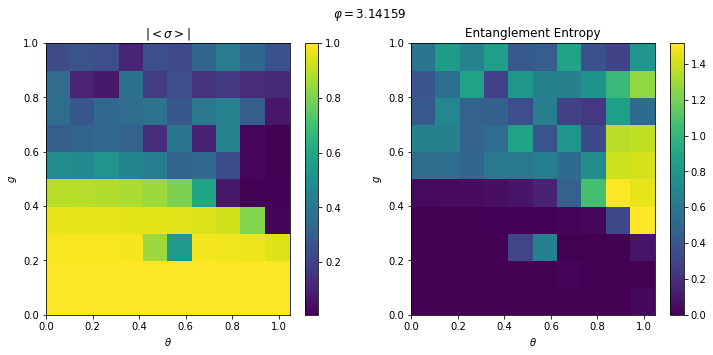

In [220]:
for dataset in data:
    fig, axes = plt.subplots(1,2, figsize=(12,5))

    c1 = axes[0].pcolor(dataset['theta'], -dataset['g'], np.abs(dataset['SigmaA']))
    c2 = axes[1].pcolor(dataset['theta'], -dataset['g'], np.abs(dataset['EE']))
    axes[0].set_title(r'$|<\sigma>|$')
    axes[1].set_title('Entanglement Entropy')
    for ax in axes:
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel(r'$g$')
    fig.colorbar(c1, ax=axes[0])
    fig.colorbar(c2, ax=axes[1])
    plt.suptitle(r'$\varphi={}$'.format(dataset['phi'][0,0]))
    plt.show()

Results obtained with $\chi = 10$, $\delta = 0.01$, $N = 500$

### Results in literature
![](plotz3.png)
*Phase diagram of the 
$\mathbb{Z}_3$ parafermionic chain with chiral interactions*
Ye Zhuang, Hitesh J. Changlani, Norm M. Tubman, and Taylor L. Hughes
Phys. Rev. B 92, 035154